In [103]:
# Initialize Otter
import otter
grader = otter.Notebook("lab02.ipynb")

# Lab 2:  Loss and risk
Welcome to the second Data 102 lab! 

The goal of this lab is to introduce loss functions in hypothesis testing problems.

The code and responses you need to fill in are represented by `...`. There is additional documentation for each part as you go along. 

## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Submission
**NOTE: This lab will be submitted using an auto-grader. Therefore, the submission instructions for this lab are different than before.**

To submit the lab: 
1. Navigate to Kernel > Restart & Run All. Ensure that all public test cases pass locally. 
2. Save your notebook under File > Save and Checkpoint. If you do not save your notebook, then you might run into issues with the downloaded .zip file.
3. Run the very last cell, which generates a .zip file for you to download to your local machine. Click the “here” button to download the .zip file. You may receive an error that the .zip file was unable to be created because there was an issue with PDF generation. You need to ensure that you’ve answered all of the questions that require a manual response.
4. If your work downloads as several independent files rather than as a .zip, you are likely using Safari on a Mac. Follow these instructions to make sure you can download your work as a zip: https://macreports.com/how-to-download-zip-files-without-unzipping/
5. Upload this .zip to the correct assignment on Gradescope. After submitting, the autograder built-in to the Gradescope assignment will tell you which public test cases you’ve passed and failed. There are no hidden test cases.

**For full credit, this assignment should be completed and submitted before Wednesday, September 14, 2022 at 11:59 PM. PT**

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import itertools
from ipywidgets import interact, interactive

import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

def get_hash(num):
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

# Question 1: Custom Loss Functions for Hypothesis Testing

The first question looks at a medical diagnostic decision. For each person that undergoes testing, the null hypothesis is that they don't have the virus, and the alternative is that they do.

_The null hypothesis_ $H_0$: Person $X$ does not have the virus.

_The alternative hypothesis_ $H_1$: Person $X$ has the virus.

Suppose that you devise a test which takes some measurements from each test subject and then computes a corresponding p-value.

Last week, we looked at several approaches for controllling False Positive Rate (FPR), Family Wise Error Rate (FWER) and False Discovery Rate (FDR). However, they all have some drawbacks for medical decision making: FPR and FWER do not depend on the prevalence of the disease and neither of them allows a decision maker to consider different misclassification costs arising from false-negative and false-positive diagnoses.

When making medical decisions, wrong diagnoses carry different costs. Deciding that a patient does not have the virus when in reality they do is a **False Negative**. The potential consequences of such a decision are severe: lack of treatment, risk of infecting others, and even premature death.

On the other hand, deciding that a patient has the virus when in reality they don't is a **False Positive**. The potential consequences of that include distress, unnecesary treatment and costs of subsequent testing. This is certainly not ideal, but less severe than the consequences of a false negative.

We've previously evaluated decisions in terms of their TPR and FPR, and showed how ROC curves demonstrate the trade-off curve between the two quantities. We saw that it is not always clear how to choose the best trade-off.

A very popular way of choosing the trade-off, and simultaneously comparing different procedures, is the idea of **risk** that we learnt in Lecture 5. Here, the analyst constructs a loss function by specifying the **cost** of making each type of mistake.


### Question 1a

Let's assume that we estimate the cost of making a false negative mistake to be $k$-times larger than the cost of a false positive. We can express that via a **loss function**, shown below:

$$\begin{cases} \mathcal{l}(D=1|R=0) = 1\\
\mathcal{l}(D=0|R=1) = ~?\\
\mathcal{l}(D=0|R=0)=\mathcal{l}(D=1|R=1) = 0\end{cases}$$

What should be the value of $~?$ in the equation above? Assign your answer to the variable `question_mark` below **as a string**.

<!--
BEGIN QUESTION
name: q1ai
manual: false
points: 1
-->

In [105]:
question_mark = 'k' # SOLUTION

In [106]:
grader.check("q1ai")

q1ai results: All test cases passed!

<!-- BEGIN QUESTION -->

Do FPR and FWER depend on the prevalence of the disease?

<!--
BEGIN QUESTION
name: q1aii
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:**
No, see text above.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Above, you were given one example of when the consequences of a False Negative is more severe than the consequences of a False Positive. Come up with one example of the opposite: when the consequences of a False Positive is more severe than the consequences of a False Negative.

<!--
BEGIN QUESTION
name: q1aiii
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:**
E.g. granting someone security clearance. 

<!-- END QUESTION -->

## 1.b: Compute average empirical loss

Assume we have a sample of $N$ patients for which a test outputs the following confusion matrix: 

|             | Decision = 0 | Decision = 1 |
|-------------|--------------|--------------|
| Reality = 0 | TN           | FP           |
| Reality = 1 | FN           | TP           |

### Compute the average loss this procedure incurs by summing up the losses for every mis-diagnosis and then dividing by the total number of tests.

<!--
BEGIN QUESTION
name: q1b
manual: false
points: 1
-->

In [107]:
def compute_average_loss(results_dictionary, factor_k):
    """ Function that computes average loss for a given confusion matrix and a multiplicative
        factor_k that compares the consequences of false nagatives and false positives.
        
        Inputs:
            results_dictionary : a dictionary with the counts of TP, FP, TN and FN
            factor_k : float, quantifies the ratio of the negative consequences of
                       false negatives compared to false positives
                       
        Outputs:
            average_loss : float
    """
    
    TP_count = results_dictionary['TP_count']
    FP_count = results_dictionary['FP_count']
    TN_count = results_dictionary['TN_count']
    FN_count = results_dictionary['FN_count']
    
    # BEGIN SOLUTION
    N = TP_count + TN_count + FP_count + FN_count
    average_loss = (FP_count + FN_count*factor_k)/N
    return average_loss
    # END SOLUTION

In [108]:
grader.check("q1b")

q1b results: All test cases passed!

## 1.c: Compute the average loss (empirical risk) with respect to various levels $\alpha$

In this part, we will use a simple test that rejects the null hypothesis whenever the p-value of a patient is smaller than some level $\alpha$. 

Our goal is to investigate the performance of the test at different levels with respect to the custom loss defined in **1.b**. 

Recall the naive test from Lab 01:

In [109]:
def alpha_threshold_decisions(p_values, alpha):
    """
    Returns decisions on p-values using naive thresholding.
    
    Inputs:
        p_values: array of p-values
        alpha: threshold (significance level)
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant at level `alpha`, and 0 otherwize
    """
    decisions = p_values <= alpha
    return decisions

Let's also bring in from Lab 01 the function that computes the counts of TP, TN, FP, FN by comparing the decision to the reality.

In [110]:
def report_results(decisions, reality):
    """
    Produces a dictionary with counts for the true positives, true negatives,
    false negatives, and false positives from the input `decisions`
    and `reality` arrays.
    
    Inputs:
      decision: array of 0/1 values where 1 indicates that patient has the virus.
      reality: array of 0/1 values where 1 indicates a draw from the alternative.
    
    Outputs: a dictionary of TN, TP, FN, and FP counts.
    """   
    
    TP_count = np.sum(decisions*reality)
    TN_count = np.sum((1-decisions)*(1-reality))
    FP_count = np.sum((decisions)*(1-reality))
    FN_count = np.sum((1-decisions)*(reality))
    
    results_dictionary = {"TN_count": TN_count,
                          "TP_count": TP_count,
                          "FN_count": FN_count,
                          "FP_count": FP_count,
                         }
    return results_dictionary

First, we will generate ground truth data. 

Assume there are $N$ subjects, out of which a fraction truly have the virus. This fraction is known as **prevalence**: $\mathbb{P}\{R=1\}$.

The function below generates p-values associated with each test subject. 

In [111]:
def generate_ground_truth(N, prevalence):
    """ Creates simulated p-values corresponding to N subjects at a 
    specified disease prevalence level"""
    rs = np.random.RandomState(1)
    reality = rs.binomial(1, prevalence, N)
    p_values = 1 - norm.cdf(rs.randn(N) + reality)
    return(p_values, reality)

In [112]:
N = 10000
prevalence = 0.1
p_values, reality = generate_ground_truth(N, prevalence)

### In the cell below complete the function that computes the average loss (empirical risk) for an $\alpha$ level test.

<!--
BEGIN QUESTION
name: q1c
manual: false
points: 1
-->

In [113]:
# TODO: complete the function
def compute_alpha_average_loss(p_values, reality, alpha, factor_k):
    """ 
    Computes the observed average loss for an alpha level test.
    
    Inputs:
        p_values: array of floats, p-value[i] is the p-values associated with test subject i.
        reality: array of 0/1s
        alpha: float, threshold for rejecting the null hypothesis
        factor_k: float, quantifies the ratio of the negative consequences of
                  false negatives compared to false positives
                  
    Outputs:
        average_loss: float, average observed loss
    """
    
    # HINT: Your code should take advantage of functions already defined in this notebook.
    
    # BEGIN SOLUTION
    decisions = alpha_threshold_decisions(p_values, alpha)
    results = report_results(decisions, reality)
    average_loss = compute_average_loss(results, factor_k)
    return average_loss
    # END SOLUTION

In [114]:
grader.check("q1c")

q1c results: All test cases passed!

## 1.d Investigate the average loss plot for different levels of disease prevalence 
The function below generates ground truth for a sample of 10000 subjects for a given disease prevalence. It then computes the average loss for diagnostic decisions at level $\alpha$, where $\alpha \in [0, 1]$ . Finally, it plots the resulting average loss (y axis) at a level $\alpha$ (x axis).

In [115]:
# Run this as is after completing the `compute_alpha_average_loss` function
# Do not modify
def plot_average_loss(prevalence, factor_k):
    N = 10000
    # generate ground truth
    p_values, reality = generate_ground_truth(N, prevalence)
    # vary alpha from 0 to 1
    alpha_array = np.arange(0,1, 0.05)
    # compute average loss for each alpha
    average_loss_array = [compute_alpha_average_loss(p_values, reality, alpha, factor_k) for alpha in alpha_array]
    optimal_alpha = alpha_array[np.argmin(average_loss_array)]
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_array, average_loss_array, label = 'Average Loss')
    plt.axvline(x=optimal_alpha, ls='--', label = 'Optimal $\\alpha$', c='green')
    plt.xlabel('$\\alpha$ level')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.show()  

In [116]:
# Visualize interactive plot: Do not modify
interactive_plot = interactive(plot_average_loss, prevalence=(0.0, 0.11, 0.01), factor_k=(0, 100, 5))
interactive_plot 

interactive(children=(FloatSlider(value=0.05, description='prevalence', max=0.11, step=0.01), IntSlider(value=…

<!-- BEGIN QUESTION -->

Fix the `prevalence` of the disease at $0.05$ ($5\%$). Using the slider in the interactive plot above, try out different values for the multiplicative `factor_k`. What do you notice? How would you adjust your diagnosic procedure based on the value of `factor_k`? What combination of `factor_k` and $\alpha$ gives you the lowest possible loss, and why?

<!--
BEGIN QUESTION
name: q1di
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION**:
Changing the value of `factor_k` changes the $\alpha$ level that minimizes the average loss. The level $\alpha$ that minimizes the average loss at `prevalence` $= 0.05$ changes depending on `factor_k`: as `factor_k` increases, the $\alpha$ level should also increase to obtain the minimal loss and vice versa. 

The combination of `factor_k` and $\alpha$ with the lowest loss is $k = 0, \alpha = 0$. A `factor_k` of zero corresponds to not penalizing false negatives, and so the optimal decision rule is to always return $D=0$. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Fix `factor_k` at $50$ (meaning that the negative consequence of a false negative are 50 times larger than the negative consequences of a false positive). Using the slider in the interactive plot above, try out different values for the true prevalence of the disease. What do you notice? How would you adjust your diagnostic procedure based on the prevalence of the disease? What combination of prevalence and $\alpha$ gives you the lowest possible loss, and why?

<!--
BEGIN QUESTION
name: q1dii
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION**:
Changing the value of `prevalence` changes the $\alpha$ level that minimizes the average loss. The level $\alpha$ that minimizes the average loss at `factor_k` $= 50$ changes depending on `factor_k`: as `prevalence` increases, the $\alpha$ level should also increase to obtain the minimal loss and vice versa. 

An average loss of $0$ is achievable when `prevalence` equals either $0$ or $1$. In this case, all $R$ take on the same value and so we can get every decision right with a threshold of $\alpha =0$ and $\alpha = 1$ respectively.

<!-- END QUESTION -->


# Question 2.
In the previous question you played the role of a test designer or device manufacturer that needs to find an appropriate way to calibrate the test such that it minimizes some desired loss. In this part put yourself in the shoes of a medical professional who is using this testing device without really knowing all the internals of it. 

The test kit claims a certain specificity ($1-FPR$) and sensitivity ($1-FNR$). 

Assume you have a new patient that came in and tested positive (you have only the binary output of the test). Your goal is to determine whether or not to put this patient through treatment.

To answer this we will make the following assumptions:
- Assume as in part 1, that getting a false negative is $k$ times worse than getting a false positive.
- Assume that you know the `prevalence` of this disease.
- Assume that the test has a certain `specificity` and `sensitivity`.

## 2.a Compute the posterior
Complete the function below to compute the posterior probability that the patient truly has the disease conditioned on a positive test result: namely, compute $\mathbb{P}\{R=1|D=1\}$ as a function of `prevalence`, `sensitivity` and `specificity`.

*Hint: We've already seen this in HW1 and discussion 2*

<!--
BEGIN QUESTION
name: q2a
manual: false
points: 1
-->

In [117]:
def compute_posterior_probability(prevalence, sensitivity, specificity):
    """ 
    Computes the posterior probability that the patient trully has the disease 
    conditioned on a positive test result.
    
    Inputs: 
        prevalence: float, fraction of the population that has the disease
        sensitivity: float, 1 - false negative rate
        specificity: float, 1 - false positive rate
        
    Outputs:
        posterior probability: probability that the patient has the disease given a positive test result
    """
    # BEGIN SOLUTION
    TP = sensitivity
    FP = 1 - specificity
    # END SOLUTION
    posterior_probability = (TP * prevalence) / (TP * prevalence + FP * (1-prevalence)) # SOLUTION
    return round(posterior_probability, 3)

In [118]:
grader.check("q2a")

q2a results: All test cases passed!

In [119]:
# Let's compute a few posterior probabilities
prevalence = [0.001, 0.1]
sensitivity = 0.98
specificity = 0.99
print('Conditioned on a positive test result, with sensitivity {} and specificity {}:'.format(sensitivity, specificity))
print('For a low prevalence disesase ({}), the posterior probability that the test subject is truly positive is {:.3f}'.
      format(prevalence[0], compute_posterior_probability(prevalence[0], sensitivity, specificity)))
print('For a high prevalence disesase ({}), the posterior probability that the test subject is truly positive is {:.3f}'.
      format(prevalence[1], compute_posterior_probability(prevalence[1], sensitivity, specificity)))


Conditioned on a positive test result, with sensitivity 0.98 and specificity 0.99:
For a low prevalence disesase (0.001), the posterior probability that the test subject is truly positive is 0.089
For a high prevalence disesase (0.1), the posterior probability that the test subject is truly positive is 0.916


## 2.b Compute expected loss function with respect to posterior distribution

Given that the test returned a positive result (that $D=1$), you can make one of two posible decisions:
 - $T = 1$: start the treatment
 - $T = 0$: do not start the treatment despite the positive test result
 
Similarly to Question 1, let's assume that we estimate the cost of not treating a truly sick patient to be $k$ times larger than the cost of treating a patient that is not truly sick.

Recall from lecture that a loss function takes in a hidden state of the world $\theta$ (in this case, that's the reality $R$: whether or not the patient is sick), and a decision $\delta$ (in this case, that's $T$: whether or not to treat). Our loss function has the formula:

$$\begin{cases} \ell(R=0, T=1) = 1\\
\ell(R=1, T=0) = k\\
\ell(R=0, T=0)=\ell(R=1, T=1) = 0\end{cases}$$

### Compute the expected loss for each treatment decision, given that someone tested positive:
$$\mathbb{E}[l(R,T=0)|D=1] = ?$$
$$\mathbb{E}[l(R,T=1)|D=1] = ?$$

*Hint: Think carefully about what is random here. What's it's distribution?*

<!--
BEGIN QUESTION
name: q2b
manual: false
points: 1
-->

In [120]:
def compute_expected_loss(treatment, posterior_probability, factor_k):
    """ 
    Compute the expected loss for the treatment.
    
    Inputs:
        treatment: int 0/1 (0-no treatment, 1-treatment)
        posterior_probability: float, probability that the patient is truly sick given positive test result
        k_factor : float, quantifies the ratio of the negative consequences of
                   false negatives compared to false positives
        
    """
    
    # BEGIN SOLUTION
    if treatment == 1:
        expected_loss = 1 - posterior_probability
    else:
        expected_loss = factor_k * posterior_probability
    return expected_loss
    # END SOLUTION

In [121]:
grader.check("q2b")

q2b results: All test cases passed!

<!-- BEGIN QUESTION -->

## 2.c Loss and Risk
Is the quantity you computed above a frequentist risk, a Bayesian posterior risk, or neither? Explain why in two sentences or less.

<!--
BEGIN QUESTION
name: q2c
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION**:
Bayesian posterior risk. Calculated based on Bayesian concepts. 

<!-- END QUESTION -->

## 2.d Decide whether or not to administer the treatment by comparing the expected losses in each case.

Compare the cost for `treatment T=1` and `no treatment T=0` and choose the option with lower expected loss.

<!--
BEGIN QUESTION
name: q2d
manual: false
points: 1
-->

In [122]:
# TODO: complete the function
def make_decision(posterior_probability, factor_k):
    """
    Make a decisions to adminster or not the treatment: T=1 or T=0 .
    
    Inputs: 
        posterior_probability: float, probability that the patient is truly sick given positive test result
        k_factor : float, quantifies the ratio of the negative consequences of
                   false negatives compared to false positives
    Outputs:
        treatment: int, 0/1
    """
    # BEGIN SOLUTION
    loss_treat = compute_expected_loss(1, posterior_probability, factor_k)
    loss_no_treat = compute_expected_loss(0, posterior_probability, factor_k)
    
    treatment = 1 if loss_treat < loss_no_treat else 0
    return treatment
    # END SOLUTION

In [123]:
grader.check("q2d")

q2d results: All test cases passed!

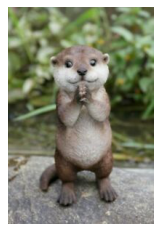

In [124]:
import matplotlib.image as mpimg
img = mpimg.imread('baby_otter.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
plt.show()

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [125]:
grader.check_all()

q1ai results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

q2d results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [126]:
# Save your notebook first, then run this cell to export your submission.
grader.export()

There was an error generating your LaTeX; showing full error message:
Failed to run "['xelatex', 'notebook.tex', '-quiet']" command:
This is XeTeX, Version 3.141592653-2.6-0.999993 (TeX Live 2021) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./notebook.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2021-11-22> (/Users/aidanmcloughlin/Library/TinyTeX/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/Users/aidanmcloughlin/Library/TinyTeX/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `xeCJK.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.17 ^^M
        
No pages of output.
Transcript written on notebook.log.

If the error above is related to xeCJK or fandol in LaTeX and you don't require this functionality, try running again with no_xecjk set to True or the

/Users/aidanmcloughlin/miniforge3/envs/m1_tf3/lib/python3.8/site-packages/otter/check/notebook.py:385: UserWarning: Could not locate a PDF to include
  warnings.warn("Could not locate a PDF to include")
